In [1]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from scipy.optimize import minimize
from itertools import combinations
import tabulate

from climada.entity import Exposures
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone

from climada.engine import ImpactCalc

from climada.hazard import TCTracks, Centroids, TropCyclone

from climada.util.api_client import Client
import climada.util.yearsets as yearsets


# Parameters


In [2]:
# The company data file name
cpnys_file_name = 'Data/Company data/Company examples & locations.xlsx'

# Give the coverage limit and deductible for all companies
# coverage_limit should in prct of the asset value in range [50, 100] %%!
# deductible should be in prct of the asset value in range [0, 10] %%!
coverage_limit =  50
deductible = 1

# The return period
return_period = 100

# The alpha value for the VaR and ES calculation ( Move to back)
alpha = 1/return_period

# The number of years to simulate
n_years = 10000



# Initiate Hazard, Impact function and Exposures

## Hazard objects

{'res_arcsec': ['150'], 'event_type': ['synthetic', 'observed'], 'model_name': ['random_walk', 'STORM'], 'spatial_coverage': ['global', 'country', 'genesis_basin', 'basin'], 'climate_scenario': ['rcp26', 'rcp45', 'rcp60', 'None', 'rcp85'], 'ref_year': ['2040', '2060', '2080'], 'country_iso3alpha': ['AFG', 'ARE', 'BGD', 'BHR', 'BRN', 'BTN', 'CHN', 'DJI', 'EGY', 'ERI', 'ETH', 'FSM', 'GUM', 'HKG', 'IDN', 'IND', 'IRN', 'IRQ', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KOR', 'KWT', 'LAO', 'LKA', 'MAC', 'MDV', 'MHL', 'MMR', 'MNG', 'MNP', 'MYS', 'NPL', 'OMN', 'PAK', 'PHL', 'PLW', 'PRK', 'QAT', 'RUS', 'SAU', 'SDN', 'SGP', 'SOM', 'SYR', 'THA', 'TWN', 'USA', 'VNM', 'YEM', 'ALA', 'ALB', 'DZA', 'AND', 'AGO', 'AIA', 'ATG', 'ARG', 'ABW', 'AUS', 'AUT', 'BHS', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BIH', 'BWA', 'BRA', 'IOT', 'BGR', 'BFA', 'BDI', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'COL', 'COM', 'COG', 'COD', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CZE', 'DNK', 'DMA', 'DOM', 'ECU', 'SLV', 

<GeoAxes: title={'center': 'TC max intensity at each point'}>

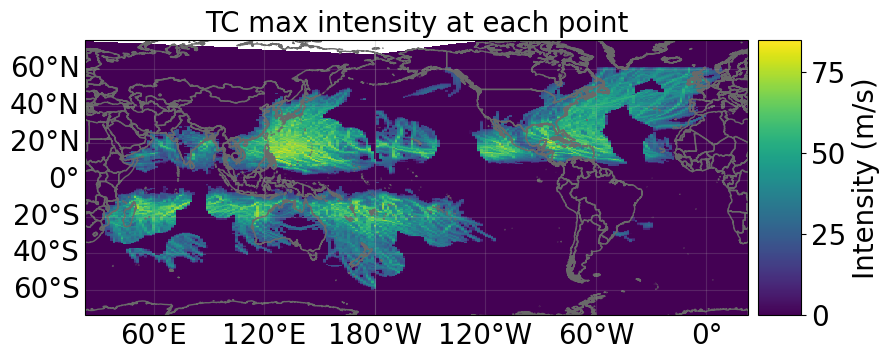

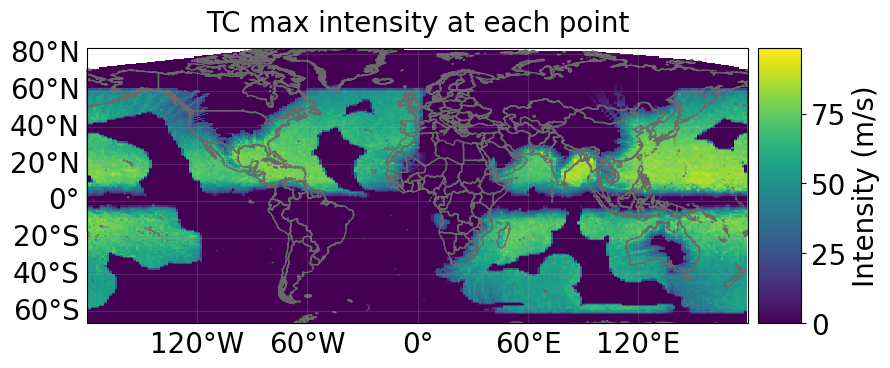

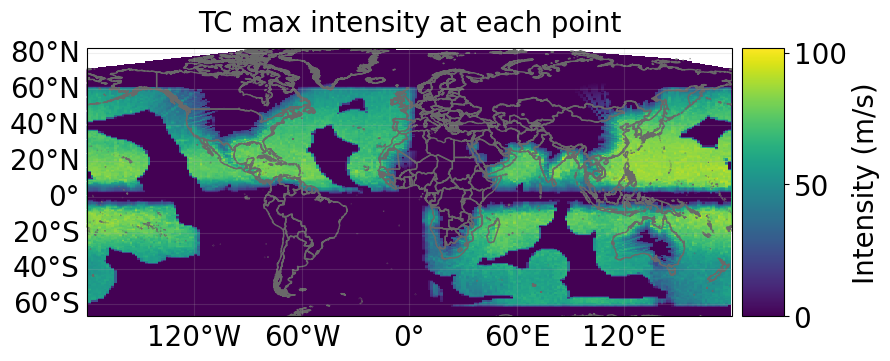

In [3]:
# Make a dictionary and store historical, current and future hazard sets

# Define time period
time_periods = ['historical', 'current', 'future']

# Initialise the client
client = Client()

# Get the hazard set info
hazard_type = 'tropical_cyclone'
info_tc = client.list_dataset_infos('tropical_cyclone')
print(client.get_property_values(info_tc))

# Store the currrent hazard sets in a dictionary
haz_dict = {time_period: None for time_period in time_periods}

# Get the current hazard set
properties_curr = {'model_name': 'STORM', 'spatial_coverage': 'global', 'name':'TC_global_0300as_STORM'}
haz_dict[time_periods[1]] = client.get_hazard(hazard_type, properties=properties_curr)

# Select future hazard set
# Available future hazard sets
available_fut_haz_sets = ['TC_global_0300as_STORM_CNRM-CM6-1-HR', 'TC_global_0300as_STORM_EC-Earth3P-HR'] # Available future hazard sets from the API 
properties_fut = {'model_name': 'STORM', 'spatial_coverage': 'global', 'name': available_fut_haz_sets[0]}
haz_dict[time_periods[2]] = client.get_hazard(hazard_type, properties=properties_fut)

# Get the historical hazard set
properties_curr = { 'spatial_coverage': 'global', 'event_type': 'observed' }
haz_dict[time_periods[0]] = client.get_hazard(hazard_type, properties=properties_curr)
#all_tracks = TCTracks.from_ibtracs_netcdf()
#haz_dict[time_periods[0]] = TropCyclone.from_tracks(all_tracks, centroids=copy.deepcopy(haz_dict[time_periods[1]].centroids)) # Get centroids from current hazard set to speed up the computation

# Plot the hazard set
#haz_dict[time_periods[0]].plot_intensity(0) # Plot historical hazard set
haz_dict[time_periods[0]].plot_intensity(0) # Plot current hazard set
haz_dict[time_periods[1]].plot_intensity(0) # Plot current hazard set
haz_dict[time_periods[2]].plot_intensity(0) # Plot future hazard set

In [4]:
# Get the possible years for the simulation

# Take the first 4 letters of the string and convert it to an integer
possible_years = [int(haz_dict['historical'].event_name[i][:4]) for i in range(len(haz_dict['historical'].event_name))]
# Get the unique values
possible_years = list(set(possible_years))


# Create the year sets a dictionary that maps the year set name to the years
hist_year_event_name_dict ={year: [] for year in possible_years}
hist_year_event_id_dict = {year: [] for year in possible_years}
for event_id, event_name in zip(haz_dict['historical'].event_id, haz_dict['historical'].event_name):
    year = int(event_name[:4])
    hist_year_event_name_dict[year].append(event_name)
    hist_year_event_id_dict[year].append(event_id)

# Make all the lists in  hist_year_event_id_dict unique to numpy arrays
hist_yearsets = [ np.array(event_ids) for year, event_ids in hist_year_event_id_dict.items()]


## Impact functions

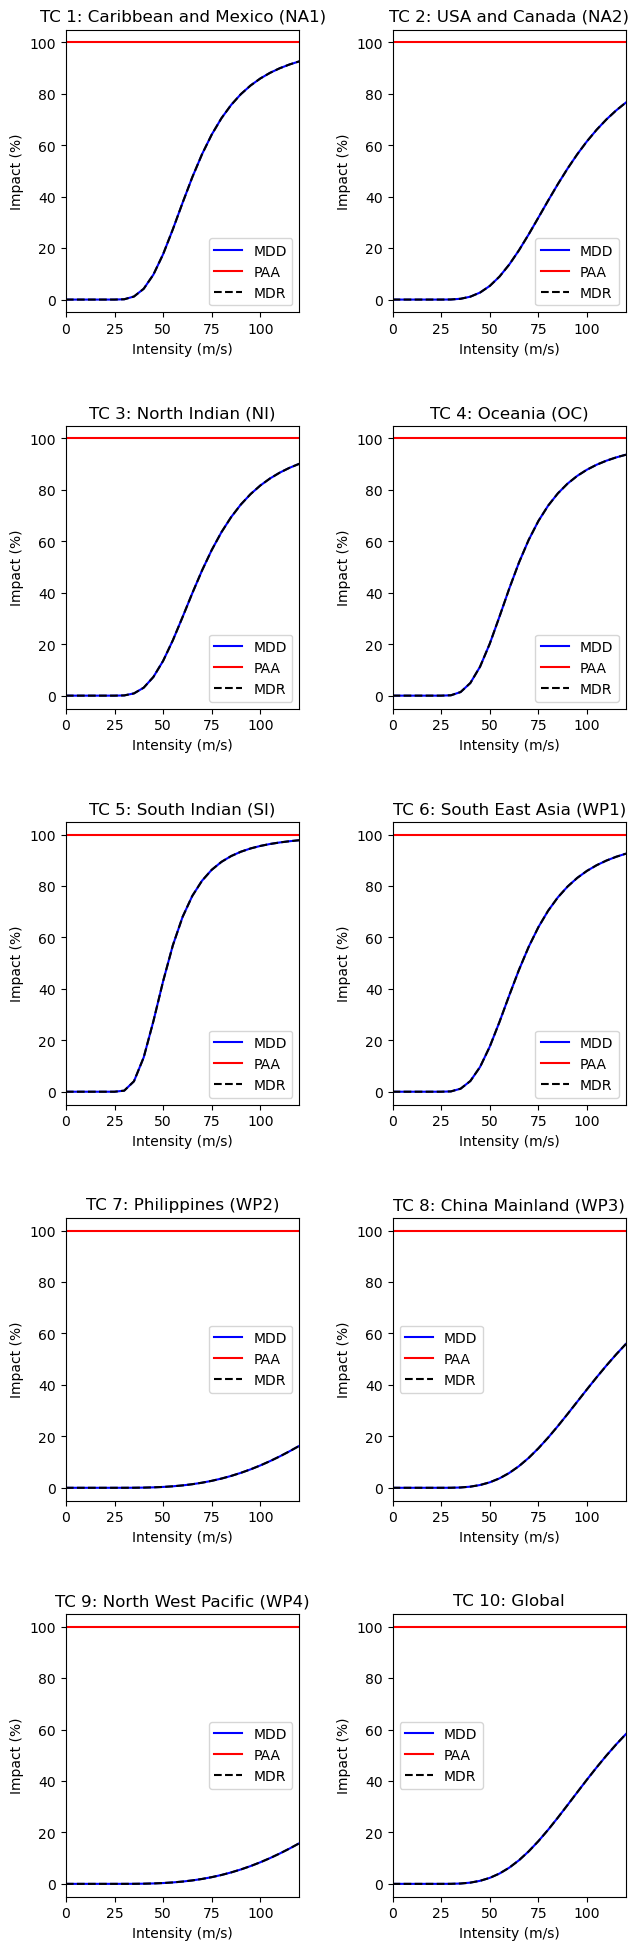

In [5]:
# generate the default calibrated TC impact functions for different regions
imp_fun_set_TC = ImpfSetTropCyclone.from_calibrated_regional_ImpfSet()

# plot all the impact functions
imp_fun_set_TC.plot()
# adjust the plots
plt.subplots_adjust(right=1., top=4., hspace=0.4, wspace=0.4)

## Exposure object


In [6]:
# Read the Excel file into a pandas DataFrame
exp_df = pd.read_excel(cpnys_file_name, usecols="A:I", sheet_name = 'Property values')  #Read only columns A to H  
# Remove the rows with no location
exp_df = exp_df[exp_df['Latitude'].notna()]
# Rename the columns using a dictionary
exp_df = exp_df.rename(columns={"Latitude": "latitude", "Longitude": "longitude", "Value (US$ billion)": "value"})

In [7]:
# Map the impact function to the exposures assets 

## countries by region:
region_ids_cal = {'NA1': ['AIA', 'ATG', 'ARG', 'ABW', 'BHS', 'BRB', 'BLZ', 
                          'BMU', 'BOL', 'CPV', 'CYM', 'CHL', 'COL', 'CRI', 
                          'CUB', 'DMA', 'DOM', 'ECU', 'SLV', 'FLK', 'GUF', 
                          'GRD', 'GLP', 'GTM', 'GUY', 'HTI', 'HND', 'JAM', 
                          'MTQ', 'MEX', 'MSR', 'NIC', 'PAN', 'PRY', 'PER', 
                          'PRI', 'SHN', 'KNA', 'LCA', 'VCT', 'SXM', 'SUR', 
                          'TTO', 'TCA', 'URY', 'VEN', 'VGB', 'VIR'], \
                  'NA2': ['CAN', 'USA'], \
                  'NI': ['AFG', 'ARM', 'AZE', 'BHR', 'BGD', 'BTN', 'DJI', 
                         'ERI', 'ETH', 'GEO', 'IND', 'IRN', 'IRQ', 'ISR', 
                         'JOR', 'KAZ', 'KWT', 'KGZ', 'LBN', 'MDV', 'MNG', 
                         'MMR', 'NPL', 'OMN', 'PAK', 'QAT', 'SAU', 'SOM', 
                         'LKA', 'SYR', 'TJK', 'TKM', 'UGA', 'ARE', 'UZB', 
                         'YEM'], \
                  'OC': ['ASM', 'AUS', 'COK', 'FJI', 'PYF', 'GUM', 'KIR', 
                         'MHL', 'FSM', 'NRU', 'NCL', 'NZL', 'NIU', 'NFK', 
                         'MNP', 'PLW', 'PNG', 'PCN', 'WSM', 'SLB', 'TLS', 
                         'TKL', 'TON', 'TUV', 'VUT', 'WLF'], \
                  'SI': ['COM', 'COD', 'SWZ', 'MDG', 'MWI', 'MLI', 'MUS', 
                         'MOZ', 'ZAF', 'TZA', 'ZWE'], \
                  'WP1': ['KHM', 'IDN', 'LAO', 'MYS', 'THA', 'VNM'], \
                  'WP2': ['PHL'], \
                  'WP3': ['CHN'], \
                  'WP4': ['HKG', 'JPN', 'KOR', 'MAC', 'TWN'], 
                  'ROW': ['ALB', 'DZA', 'AND', 'AGO', 'ATA', 'AUT', 'BLR', 
                          'BEL', 'BEN', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 
                          'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'CMR', 'CAF', 
                          'TCD', 'CXR', 'CCK', 'COG', 'HRV', 'CUW', 'CYP', 
                          'CZE', 'CIV', 'DNK', 'EGY', 'GNQ', 'EST', 'FRO', 
                          'FIN', 'FRA', 'ATF', 'GAB', 'GMB', 'DEU', 'GHA', 
                          'GIB', 'GRC', 'GRL', 'GGY', 'GIN', 'GNB', 'HMD', 
                          'VAT', 'HUN', 'ISL', 'IRL', 'IMN', 'ITA', 'JEY', 
                          'KEN', 'PRK', 'XKX', 'LVA', 'LSO', 'LBR', 'LBY', 
                          'LIE', 'LTU', 'LUX', 'MLT', 'MRT', 'MYT', 'MDA', 
                          'MCO', 'MNE', 'MAR', 'NAM', 'NLD', 'NER', 'NGA', 
                          'MKD', 'NOR', 'PSE', 'POL', 'PRT', 'ROU', 'RUS', 
                          'RWA', 'REU', 'BLM', 'MAF', 'SPM', 'SMR', 'STP', 
                          'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SVK', 'SVN', 
                          'SGS', 'SSD', 'ESP', 'SDN', 'SJM', 'SWE', 'CHE', 
                          'TGO', 'TUN', 'TUR', 'UKR', 'GBR', 'UMI', 'ESH', 
                          'ZMB', 'ALA']}

code_regions = {'NA1': 1, 'NA2': 2, 'NI': 3, 'OC': 4, 'SI': 5, 'WP1': 6, \
                    'WP2': 7, 'WP3': 8, 'WP4': 9, 'ROW': 10}

# Make data frame of countries and region ids and impf_TC id
contry_basin_coderegion = {'ISO3':[], 'region_id_cal': [], 'impf_TC': []}

for key, value in region_ids_cal.items():
    contry_basin_coderegion['ISO3'] += value
    contry_basin_coderegion['region_id_cal'] += [key]*len(value)
    contry_basin_coderegion['impf_TC'] += [code_regions[key]]*len(value)

contry_basin_coderegion_df = pd.DataFrame(contry_basin_coderegion)

# Merge the data frames
exp_df = pd.merge(exp_df, contry_basin_coderegion_df, on='ISO3', how='left')

In [8]:
# Define company identifier string
company_ref = 'Industry' # Industry or Company ID

# Get the unique companies
companies = exp_df[company_ref].unique()

# Create an exposures object
exp_all = Exposures(exp_df)
# Check that the exposure data is valid
exp_all.check()

# Store the current and future exposures in a dictionary with each company as a key
exp_dict = {cpny: Exposures(exp_df[exp_df[company_ref].isin([cpny])]) for cpny in companies }

### Set insurance coverage

In [9]:
# Add the insurance data to the exposures
for cpny in companies:
    exp_dict[cpny].gdf['deductible'] = exp_dict[cpny].gdf.value * deductible / 100
    exp_dict[cpny].gdf['cover'] = exp_dict[cpny].gdf.value * coverage_limit / 100


### Total asset value

In [10]:
# Compute the total asset value for each company
asset_tot_value_dict = {cpny: exp_dict[cpny].gdf.value.sum() for cpny in companies}

# Replacement costs - Gross/net, event loss tables and return period

## Impact objects ( IMPORTANT update the net correctly!!!)

In [11]:
# Calculate the impact (brutto and netto) for the current and future hazard sets

# Define the impact types
imp_types = ['gross', 'net']

# Compute impact on historical hazard set
imp_dict = {time_period: {imp_types[0]: {}, imp_types[1]: {}} for time_period in haz_dict.keys()} # Store the absolute impact

# Compute the impact 
for time, haz in haz_dict.items():
    for cpny, exp in exp_dict.items():
        # Absolute impact
        imp_dict[time][imp_types[0]][cpny] = ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False, ignore_cover=True, ignore_deductible=True)
        imp_dict[time][imp_types[1]][cpny] = ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=False)


## Event loss tables

### Calculate the event loss tables

In [12]:
# Store the gross and net event loss tables in a dictionary of data frames
cpny_elt_dict = {time: {imp_types[0]: pd.DataFrame(), imp_types[1]: pd.DataFrame()} for time in haz_dict.keys()}

for time in imp_dict.keys():
    for imp_type in imp_dict[time].keys():
        for cpny in imp_dict[time][imp_type].keys():
            cpny_elt_dict[time][imp_type][cpny] = imp_dict[time][imp_type][cpny].at_event # Create a new column in the data frame for each company


### Calculate historical and simulated replacements costs

In [13]:
# Get the possible year sets for the historical hazard set

# Take the first 4 letters of the string and convert it to an integer
possible_years = [int(haz_dict['historical'].event_name[i][:4]) for i in range(len(haz_dict['historical'].event_name))]
# Get the unique values
possible_years = list(set(possible_years))


# Create the year sets a dictionary that maps the year set name to the years
hist_year_event_name_dict ={year: [] for year in possible_years}
hist_year_event_id_dict = {year: [] for year in possible_years}
for event_id, event_name in enumerate(haz_dict['historical'].event_name):
    # print(event_id, event_name)
    year = int(event_name[:4])
    hist_year_event_name_dict[year].append(event_name)
    hist_year_event_id_dict[year].append(event_id)

# Make all the lists in  hist_year_event_id_dict unique to numpy arrays
hist_yearsets = [ np.array(event_ids) for year, event_ids in hist_year_event_id_dict.items()]


In [14]:
# Create a data frame containing the sampled impacts for each company per year and event

# The number of years to sample impacts for (length(yimp.at_event) = sampled_years)
sampled_years = 1000

# Create a data frame containing the sampled impacts for each company per year and event
imp_per_year_dict = {time: {imp_type: pd.DataFrame() for imp_type in imp_type_dict.keys()} for time, imp_type_dict in imp_dict.items()}

sampling_vect_dict = {} # Store the sampling vector for time period

# Loop over the time periods and impact types from the imp_dict
for time, imp_type_dict in imp_dict.items():

    # Get any coapny impact object for the current time to sample the event ids
    imp_temp = imp_dict[time][imp_types[0]][cpny]

    # Get the years sets
    # Either historical
    if time == 'historical':
        # generate and store the sampling vector
        sampling_vect_dict[time] = hist_yearsets
    # Or simulate based on current and future hazard sets
    else:
        # sample number of events per sample year
        lam = np.sum(imp_temp.frequency)
        events_per_year = yearsets.sample_from_poisson(sampled_years, lam)

        # generate and store the sampling vector
        sampling_vect_dict[time] = yearsets.sample_events(events_per_year, imp_temp.frequency)

    # calculate the absolute and relative sampled impact per year and event for each company and store in a data frame
    for imp_type, cpny_dict in imp_type_dict.items():

        # Store the financial impact for each company per year and event in a data frame where each column is a company
        for cpny, imp in cpny_dict.items():
            # Store the impact per year for each company
            imp_per_year_dict[time][imp_type][cpny] = yearsets.compute_imp_per_year(imp, sampling_vect_dict[time]) 


In [15]:
def generate_sampled_imp_per_year(sampled_years, imp_dict, cpny_dict, hist_yearsets = None):

    # Create a data frame containing the sampled impacts for each company per year and event
    imp_per_year_dict = {time: {imp_type: pd.DataFrame() for imp_type in imp_type_dict.keys()} for time, imp_type_dict in imp_dict.items()}

    sampling_vect_dict = {} # Store the sampling vector for time period

    # Loop over the time periods and impact types from the imp_dict
    for time, imp_type_dict in imp_dict.items():

        # Get any coapny impact object for the current time to sample the event ids
        imp_temp = imp_dict[time][imp_types[0]][list(cpny_dict.keys())[0]]

        # Get the years sets
        # Either historical
        if hist_yearsets and time == 'historical':
            # generate and store the sampling vector
            sampling_vect_dict[time] = hist_yearsets
        # Or simulate based on current and future hazard sets
        else:
            # sample number of events per sample year
            lam = np.sum(imp_temp.frequency)
            events_per_year = yearsets.sample_from_poisson(sampled_years, lam)

            # generate and store the sampling vector
            sampling_vect_dict[time] = yearsets.sample_events(events_per_year, imp_temp.frequency)

        # calculate the absolute and relative sampled impact per year and event for each company and store in a data frame
        for imp_type, cpny_dict in imp_type_dict.items():

            # Store the financial impact for each company per year and event in a data frame where each column is a company
            for cpny, imp in cpny_dict.items():
                # Store the impact per year for each company
                imp_per_year_dict[time][imp_type][cpny] = yearsets.compute_imp_per_year(imp, sampling_vect_dict[time])

    return imp_per_year_dict, sampling_vect_dict

# Generate the sampled impacts for the historical hazard set
imp_per_year_dict, sampling_vect_dict = generate_sampled_imp_per_year(sampled_years, imp_dict, cpny_dict, hist_yearsets = None)

In [16]:
# Generate all possible combinations of companies
cpny_combos = []
for r in range(1, len(companies) + 1):
    combinations_object = combinations(companies, r)
    combinations_list = list(combinations_object)
    cpny_combos += combinations_list

# Convert each combination to a list
cpny_combos = [list(comb) for comb in cpny_combos]


In [17]:

# Calculate the number of years when companies where mutually hit or when the portfolio was hit

# Calculate the number of years when companies where mutually hit
prct_years_mutual_hit_df = pd.DataFrame({'Company combinations': cpny_combos, time_periods[0]: np.zeros(len(cpny_combos)), time_periods[1]: np.zeros(len(cpny_combos)), time_periods[2]: np.zeros(len(cpny_combos))})
prct_portfolio_hit_df = pd.DataFrame({'Company combinations': cpny_combos, time_periods[0]: np.zeros(len(cpny_combos)), time_periods[1]: np.zeros(len(cpny_combos)), time_periods[2]: np.zeros(len(cpny_combos))})
# remove the empty list
prct_portfolio_hit_df = prct_portfolio_hit_df[prct_portfolio_hit_df['Company combinations'].map(len) > 0]
# Convert the 'Company combinations' column to a tuple
prct_portfolio_hit_df['Company combinations'] = prct_portfolio_hit_df['Company combinations'].apply(tuple)
prct_years_mutual_hit_df['Company combinations'] = prct_years_mutual_hit_df['Company combinations'].apply(tuple)

# Loop over the time periods and impact types from the imp_dict
for time, imp_type_dict in imp_dict.items():
    # Check the mutual hits for the combinations
    for combo in cpny_combos:
        if combo == []:
            # Count all the rows where all values are 0 and plae in the data frame
            prct_years_mutual_hit_df.loc[prct_years_mutual_hit_df['Company combinations'] == tuple(combo), time] = (imp_per_year_dict[time][imp_types[0]] == 0).all(axis=1).sum()/imp_per_year_dict[time][imp_types[0]].shape[0]*100
        else:
            # Count all the rows where all values are greater than 0 and plae in the data frame
            prct_years_mutual_hit_df.loc[prct_years_mutual_hit_df['Company combinations'] == tuple(combo), time] = (imp_per_year_dict[time][imp_types[0]][combo] > 0).all(axis=1).sum()/imp_per_year_dict[time][imp_types[0]].shape[0]*100
            # Count all the rows where at least one value is greater than 0 and plae in the data frame
            prct_portfolio_hit_df.loc[prct_portfolio_hit_df['Company combinations'] == tuple(combo), time] = (imp_per_year_dict[time][imp_types[0]][combo] > 0).any(axis=1).sum()/imp_per_year_dict[time][imp_types[0]].shape[0]*100

# Round the values in the DataFrame to 1 decimal place
rounded_prct_years_mutual_df = prct_years_mutual_hit_df.round(1)
# Print the data frame using the print function and tabulate
print(" The percentage of years when all companies in the portfolio were hit")
print(tabulate.tabulate(rounded_prct_years_mutual_df, headers='keys', tablefmt='pretty'))
print("\n")


# Round the values in the DataFrame to 1 decimal place
rounded_prct_portfolio_hit_df = prct_portfolio_hit_df.round(1)
# Print the data frame using the print function and tabulate
print(" The percentage of years when portfolio was hit")
print(tabulate.tabulate(rounded_prct_portfolio_hit_df, headers='keys', tablefmt='pretty'))


 The percentage of years when all companies in the portfolio were hit
+---+---------------------------------------------------------------------------------+------------+---------+--------+
|   |                              Company combinations                               | historical | current | future |
+---+---------------------------------------------------------------------------------+------------+---------+--------+
| 0 |                        ('Semiconductor manufacturing',)                         |    89.9    |  86.5   |  89.9  |
| 1 |                        ('Pharmaceutical manufacturing',)                        |    73.9    |  69.7   |  77.6  |
| 2 |                                ('Real estate ',)                                |    48.7    |  35.2   |  35.8  |
| 3 |         ('Semiconductor manufacturing', 'Pharmaceutical manufacturing')         |    67.4    |  62.0   |  70.1  |
| 4 |                 ('Semiconductor manufacturing', 'Real estate ')                 |   

In [18]:
# Calculate the conditional probability of a company being hit given that another company was hit

# seta as index the different companies 
conditional_prob_dict = {time: pd.DataFrame(index=companies, columns=companies) for time in haz_dict.keys()}

for time, conditional_prob_df in conditional_prob_dict.items():
    for cpny_1 in companies:
        for cpny_2 in companies:
            # Calculate the conditional probability of a company being hit given that another company was hit
            conditional_prob_dict[time].loc[cpny_1, cpny_2] = (imp_per_year_dict[time][imp_types[0]][[cpny_1, cpny_2]] > 0).all(axis=1).sum() / (imp_per_year_dict[time][imp_types[0]][cpny_1] > 0).sum()

# Convert the DataFrame to a numeric type and round
rounded_conditional_prob_df = {time: conditional_prob_dict[time].astype(float).round(2) for time in conditional_prob_dict.keys()}
haz_set_temp = time_periods[0]
print(f' The conditional probability of a company being hit given that another company was hit for the {haz_set_temp} hazard set')
print(tabulate.tabulate(rounded_conditional_prob_df[time_periods[0]], headers='keys', tablefmt='pretty'))
        

 The conditional probability of a company being hit given that another company was hit for the historical hazard set
+------------------------------+-----------------------------+------------------------------+--------------+
|                              | Semiconductor manufacturing | Pharmaceutical manufacturing | Real estate  |
+------------------------------+-----------------------------+------------------------------+--------------+
| Semiconductor manufacturing  |             1.0             |             0.75             |     0.49     |
| Pharmaceutical manufacturing |            0.91             |             1.0              |     0.52     |
|         Real estate          |             0.9             |             0.78             |     1.0      |
+------------------------------+-----------------------------+------------------------------+--------------+


## Risk metrics

### Get the portfolio weights for each strategy (except optimal) 

In [19]:
# Begin by defining the portfolio compositions
portfolio_strategies = cpny_combos + [['Optimal']]

# Define the data frame
portfolio_weights_base_df = pd.DataFrame({'Company combinations': portfolio_strategies})

# Add the columns for the companies
for cpny in companies:
    portfolio_weights_base_df[cpny] = np.zeros(len(portfolio_strategies))

# Count the number of companies in each portfolio and devide the value by the number of companies
for i, cpny_combo in enumerate(portfolio_strategies):
    if cpny_combo == ['Optimal']:
        portfolio_weights_base_df.loc[i, companies] = np.nan
    else:
        n_cpny = len(cpny_combo)
        for cpny in cpny_combo:
            portfolio_weights_base_df.loc[i, cpny] = 1/n_cpny

# Print the portfolio weights
print(" The portfolio weights")
print(tabulate.tabulate(portfolio_weights_base_df, headers='keys', tablefmt='pretty'))
print("\n")


 The portfolio weights
+---+---------------------------------------------------------------------------------+-----------------------------+------------------------------+--------------------+
|   |                              Company combinations                               | Semiconductor manufacturing | Pharmaceutical manufacturing |    Real estate     |
+---+---------------------------------------------------------------------------------+-----------------------------+------------------------------+--------------------+
| 0 |                         ['Semiconductor manufacturing']                         |             1.0             |             0.0              |        0.0         |
| 1 |                        ['Pharmaceutical manufacturing']                         |             0.0             |             1.0              |        0.0         |
| 2 |                                ['Real estate ']                                 |             0.0             |          

### Create the base results df

In [20]:
base_results_df = pd.DataFrame({'Company combinations': portfolio_strategies})

# Add the time periods as columns
VaR_cols = [time + '_VaR' for time in time_periods]
ES_cols = [time + '_ES' for time in time_periods]
RP_cols = [time + '_RP' for time in time_periods]
result_cols = RP_cols + VaR_cols + ES_cols
for time in result_cols:
    base_results_df[time] = 0.0


# Create the base results dictionaries
results_dict = {result_type: {'gross': base_results_df.copy(), 'net': base_results_df.copy()} for result_type in ['abs', 'rel'] }

# Create the base weights dictionary 
weights_dict = {
    result_type: {
        'gross': {time: portfolio_weights_base_df.copy() for time in time_periods},
        'net': {time: portfolio_weights_base_df.copy() for time in time_periods}
    } for result_type in ['abs', 'rel']
}

In [21]:
weights_dict

{'abs': {'gross': {'historical':                                 Company combinations  \
   0                      [Semiconductor manufacturing]   
   1                     [Pharmaceutical manufacturing]   
   2                                     [Real estate ]   
   3  [Semiconductor manufacturing, Pharmaceutical m...   
   4        [Semiconductor manufacturing, Real estate ]   
   5       [Pharmaceutical manufacturing, Real estate ]   
   6  [Semiconductor manufacturing, Pharmaceutical m...   
   7                                          [Optimal]   
   
      Semiconductor manufacturing  Pharmaceutical manufacturing  Real estate   
   0                     1.000000                      0.000000      0.000000  
   1                     0.000000                      1.000000      0.000000  
   2                     0.000000                      0.000000      1.000000  
   3                     0.500000                      0.500000      0.000000  
   4                     0.500000  

## Expected shortfall

### Simulate replacements costs

In [22]:
# Generate the sampled impacts for the historical hazard set
imp_per_year_dict, sampling_vect_dict = generate_sampled_imp_per_year(sampled_years, imp_dict, cpny_dict, hist_yearsets = None) # Here we do not use the historical yearsets

### Make a function to calc expected shortfall

In [23]:
# Make a function that calculates the expected shortfall and value at risk for a portfolio of companies
def calc_var_es_port(cpny_weights, sim_costs, denominators, alpha):
    # Calculate the portfolio losses
    sim_port_losses = -1*np.sum(cpny_weights*sim_costs/denominators, axis=1)
    # Calculate the value at risk
    var = np.quantile(sim_port_losses, alpha)
    # Calculate the expected shortfall
    es = np.mean(sim_port_losses[sim_port_losses <= var])
    return var, es

# Make an example of how to use the function
# Define the portfolio weights all companies have the same weight 
cpny_weights = [0,0,1] #np.ones(len(companies))/len(companies)
# Define the simulated costs
sim_costs = imp_per_year_dict['historical']['gross'][companies].values
# Define the denominators
denominators = np.ones(len(companies))
# Define the alpha value
alpha = 1/return_period
# Calculate the value at risk and expected shortfall
var, es = calc_var_es_port(cpny_weights, sim_costs, denominators, alpha)
print(f'The value at risk is {var} and the expected shortfall is {es}')

The value at risk is -0.5741976505389966 and the expected shortfall is -0.5951274560699591


### Make a function to optimize the expected shortfall

In [24]:
# Make a function that finds to optimal portfolio weights that minimizes the expected shortfall or value at risk for a given impact list

def find_optimal_portfolio_weights_var_es(sim_costs, denominators, alpha, metric = 'var'):

    # Get the number of companies
    n_cpny = np.shape(sim_costs)[1]

    # Define the objective function
    if metric == 'var':
        # Define the objective function
        def objective(cpny_weights, sim_costs, denominators, alpha):
            return -1*calc_var_es_port(cpny_weights, sim_costs, denominators, alpha)[0]
    elif metric == 'es':
        # Define the objective function
        def objective(cpny_weights, sim_costs, denominators, alpha):
            return -1*calc_var_es_port(cpny_weights, sim_costs, denominators, alpha)[1]

    # Define the constraints
    def constraint1(cpny_weights):
        return np.sum(cpny_weights) - 1

    def constraint2(cpny_weights):
        return cpny_weights

    # Define the initial guess
    initial_guess = np.ones(n_cpny) / n_cpny

    # Define the bounds
    bounds = [(0, 1) for i in range(n_cpny)]

    # Define the constraints
    constraints = [{'type': 'eq', 'fun': constraint1},
                   {'type': 'ineq', 'fun': constraint2}]

    # Find the optimal portfolio weights
    opt_res = minimize(objective, initial_guess, args=(sim_costs, denominators, alpha), method='SLSQP', bounds=bounds, constraints=constraints)

    # Return the optimal portfolio weights
    return opt_res.x

# Try the function
# Define the simulated costs
sim_costs = imp_per_year_dict['historical']['gross'][companies].values
# Define the denominators
denominators = np.ones(len(companies))
# Define the alpha value
alpha = 1/return_period
# Find the optimal portfolio weights for the value at risk
optimal_weights_var = find_optimal_portfolio_weights_var_es(sim_costs, denominators, alpha, metric = 'es')
print(f'The optimal portfolio weights for the value at risk are {optimal_weights_var}')
# Print the optimal portfolio weights and the value at risk and 
var, es = calc_var_es_port(optimal_weights_var, sim_costs, denominators, alpha)

The optimal portfolio weights for the value at risk are [0.80695872 0.18332597 0.00971531]


### Make a function to calc return period

In [25]:
# Make a function that calculates the return period and aai for a given impact list and portfolio weights
def calc_imp_metric(cpny_weights, imp_list, denominators, return_period = 100):
    imp_port = copy.deepcopy(imp_list[0]) # gives the relative change in impact
    imp_port.at_event = np.zeros(len(imp_port.at_event))
    imp_port.aai_agg = 0.0000000
    for idx, imp in enumerate(imp_list):
        imp_port.at_event += imp.at_event*cpny_weights[idx] / denominators[idx]
        imp_port.aai_agg = imp_port.aai_agg*cpny_weights[idx] / denominators[idx]

    port_freq_curve = imp_port.calc_freq_curve(return_per=np.array([return_period]))
    port_aai_agg = imp_port.aai_agg  # Return period in prct of the total asset value
    
    return port_freq_curve.impact[0], port_aai_agg


### Calc the perfomance for each strategy

In [27]:
# denominators
tot_cpny_values = [asset_tot_value_dict[cpny] for cpny in companies]

# Loop over the time periods and impact types from the imp_dict
for time, imp_type_dict in imp_dict.items():
    for imp_type, cpny_dict in imp_type_dict.items():
        # Get the impact objects for the portfolio strategy
        sim_imp_per_year = imp_per_year_dict[time][imp_type]
        imp_list =  [imp_dict[time][imp_type][cpny] for cpny in companies]

        # Calculate the ...
        for port_strat_idx in portfolio_weights_base_df.index:
            # If optimal calc the optimal portfolio
            if 'Optimal' in portfolio_weights_base_df.loc[port_strat_idx, 'Company combinations']:
                # Get the optimal portfolio strategy
                weights_abs = find_optimal_portfolio_weights_var_es(sim_imp_per_year[companies].values,  np.ones(len(companies)), alpha, metric = 'es')
                weights_rel = find_optimal_portfolio_weights_var_es(sim_imp_per_year[companies].values,tot_cpny_values, alpha, metric = 'es')
                # Store the weights
                weights_dict['abs'][imp_type][time].loc[port_strat_idx, companies] = weights_abs
                weights_dict['rel'][imp_type][time].loc[port_strat_idx, companies] = weights_rel
            else:
                # Get the portfolio strategy
                weights_abs = portfolio_weights_base_df.loc[port_strat_idx, companies].values
                weights_rel = weights_abs

            # Calculate the portfolio ES (absolute and relative)
            var_abs, es_abs = calc_var_es_port(weights_abs, sim_imp_per_year[companies].values, np.ones(len(companies)), alpha)
            var_rel, es_rel = calc_var_es_port(weights_rel, sim_imp_per_year[companies].values, tot_cpny_values, alpha)

            # Calculate the return period (absolute and relative) and
            rp_abs, _ = calc_imp_metric(weights_abs, imp_list, list(np.ones(len(companies))), return_period)
            rp_rel, _ = calc_imp_metric(weights_rel, imp_list, tot_cpny_values, return_period)


            # Store the results
            # Absolute
            results_dict['abs'][imp_type].loc[port_strat_idx, time + '_VaR'] = -1* np.round(var_abs, 2) 
            results_dict['abs'][imp_type].loc[port_strat_idx, time + '_ES'] = -1*np.round(es_abs, 2) 
            results_dict['abs'][imp_type].loc[port_strat_idx, time + '_RP'] = np.round(rp_abs, 2) 
            # Relative
            results_dict['rel'][imp_type].loc[port_strat_idx, time + '_VaR'] =  -1*np.round(var_rel*100, 2)
            results_dict['rel'][imp_type].loc[port_strat_idx, time + '_ES'] = -1*np.round(es_rel*100, 2)
            results_dict['rel'][imp_type].loc[port_strat_idx, time + '_RP'] = np.round(rp_rel*100, 2)
            

### Print the results

In [28]:
# Print the results for the absolute and relative  ES gross and net for the different portfolio strategies for each time period
for imp_type in imp_types:
    print(f' For {imp_type.upper()} and ABSOLUTE risk for the different portfolio strategies for each time period')
    print(tabulate.tabulate(results_dict['abs'][imp_type], headers='keys', tablefmt='pretty'))
    print("\n")    
    print(f' For {imp_type.upper()} and RELATIVE risk for the different portfolio strategies for each time period')
    print(tabulate.tabulate(results_dict['rel'][imp_type], headers='keys', tablefmt='pretty'))
    print("\n")
    # print the portfolio weights
    for time in time_periods:
        print(f' The weights {imp_type.upper()} and ABSOLUTE risk for the different portfolio strategies for the {time} time period')
        print(tabulate.tabulate(weights_dict['abs'][imp_type][time], headers='keys', tablefmt='pretty'))
        print(f' The weights {imp_type.upper()} and RELATIVE risk for the different portfolio strategies for the {time} time period')
        print(tabulate.tabulate(weights_dict['rel'][imp_type][time], headers='keys', tablefmt='pretty'))

    

 For GROSS and ABSOLUTE risk for the different portfolio strategies for each time period
+---+---------------------------------------------------------------------------------+---------------+------------+-----------+----------------+-------------+------------+---------------+------------+-----------+
|   |                              Company combinations                               | historical_RP | current_RP | future_RP | historical_VaR | current_VaR | future_VaR | historical_ES | current_ES | future_ES |
+---+---------------------------------------------------------------------------------+---------------+------------+-----------+----------------+-------------+------------+---------------+------------+-----------+
| 0 |                         ['Semiconductor manufacturing']                         |     0.03      |    0.04    |   0.05    |      0.03      |    0.05     |    0.07    |     0.04      |    0.05    |   0.09    |
| 1 |                        ['Pharmaceutical manufactu

### Return periods

In [30]:
# Make a function that finds to optimal portfolio weights that minimizes the return period or AAI for a given impact list  

multiplier = 100 # To make the relative optimzer convert 

# Define the objective function
def find_optimal_portfolio_weights_rp(imp_list, denominators, return_period = 100):

    # Define the objective function
    def objective(cpny_weights, imp_list, denominators, return_period):
        return calc_imp_metric(cpny_weights, imp_list, denominators, return_period)[0]*multiplier

    # Define the constraints
    def constraint1(cpny_weights):
        return np.sum(cpny_weights) - 1

    def constraint2(cpny_weights):
        return cpny_weights
    
    # Get the minimal rp across all companies
    min_rel_rp = 10000000000
    for imp in imp_list:
        rp_temp = imp.calc_freq_curve(return_per=np.array([return_period])).impact[0]
        if rp_temp < min_rel_rp:
            min_rel_rp = rp_temp
    # Adjust the minimum rp with the multiplier
    min_rel_rp = min_rel_rp*multiplier

    # Define the initial guess
    # Start with more weight to the comapny with the lowest impact 
    aai_list = [imp.aai_agg for imp in imp_list]
    # give the asset with the lowest impact the highest weight
    initial_guess = [1 - aai / np.sum(aai_list) for aai in aai_list]

    # Define the bounds
    bounds = [(0, 1) for i in range(n_cpny)]

    # Define the constraints where on constraint is that the sum of the weights is 1, and the other is that the weights are positive and that the objective function is min_rel_rp or less
    constraints = [{'type': 'eq', 'fun': constraint1},
                   {'type': 'ineq', 'fun': constraint2},
                   {'type': 'ineq', 'fun': lambda x: min_rel_rp - objective(x, imp_list, denominators, return_period)}]                   

    # Find the optimal portfolio weights
    opt_res = minimize(objective, initial_guess, args=(imp_list, denominators, return_period), method='SLSQP', bounds=bounds, constraints=constraints)

    # Return the optimal portfolio weights
    return opt_res.x

### Optimize the portfolio weights

In [31]:

base_results_df = pd.DataFrame({'Company combinations': portfolio_strategies})

# Add the time periods as columns
for time in time_periods:
    base_results_df[time] = 0.0

# Compute the EAI and RP for each company and portfolio strategy
rp_abs_dict = {'gross': base_results_df.copy(), 'net': base_results_df.copy()} # Store the absolute EAI in a dictionary
rp_rel_dict = copy.deepcopy(rp_abs_dict) # Store the relative RP in a dictionary

# Get the portfolio weights for the different strategies
rp_rel_weights_dict = {imp_type: {time: portfolio_weights_base_df.copy() for time in time_periods} for imp_type in imp_types}
rp_abs_weights_dict = copy.deepcopy(rp_rel_weights_dict)
    
# denominators
tot_cpny_values = [asset_tot_value_dict[cpny] for cpny in companies]

# Loop over the time periods and impact types from the imp_dict
for time, imp_type_dict in imp_dict.items():
    for imp_type, cpny_dict in imp_type_dict.items():
        # Get the impact objects for the portfolio strategy
        imp_list = [imp_dict[time][imp_type][cpny] for cpny in companies]
        for port_strat_idx in portfolio_weights_base_df.index:
            # If optimal calc the optimal portfolio
            if 'Optimal' in portfolio_weights_base_df.loc[port_strat_idx, 'Company combinations']:
                # Get the optimal portfolio strategy
                rp_rel_weights_dict[imp_type][time].loc[port_strat_idx, companies] = find_optimal_portfolio_weights_rp(imp_list, tot_cpny_values, return_period)
                rp_abs_weights_dict[imp_type][time].loc[port_strat_idx, companies] = find_optimal_portfolio_weights_rp(imp_list, list(np.ones(len(companies))), return_period)
                # Calculate the portfolio impact (absolute and relative) and return period
                rel_rp, rel_aai = calc_imp_metric(rp_rel_weights_dict[imp_type][time].loc[port_strat_idx, companies].values, imp_list, tot_cpny_values, return_period)
                abs_rp, abs_aai = calc_imp_metric(rp_abs_weights_dict[imp_type][time].loc[port_strat_idx, companies].values, imp_list, list(np.ones(len(companies))), return_period)
            else:
                # Get the portfolio strategy
                weights = portfolio_weights_base_df.loc[port_strat_idx, companies].values
                # Calculate the portfolio impact (absolute and relative) and return period
                rel_rp, rel_aai = calc_imp_metric(weights, imp_list, tot_cpny_values, return_period)
                abs_rp, abs_aai = calc_imp_metric(weights, imp_list, np.ones(len(companies)), return_period)
                
            # Store the absolute and relative EAI and RP in a dictionary
            rp_abs_dict[imp_type].loc[port_strat_idx, time] = abs_rp
            rp_rel_dict[imp_type].loc[port_strat_idx, time] = rel_rp * 100



In [ ]:
# Print the results for the absolute and relative  RP gross and net for the different portfolio strategies for each time period
for imp_type in imp_types:
    print(f' The absolute RP {imp_type} for the different portfolio strategies for each time period')
    print(tabulate.tabulate(rp_abs_dict[imp_type], headers='keys', tablefmt='pretty'))
    print("\n")
    print(f" The relative RP for the {imp_type} impact type")
    print(tabulate.tabulate(rp_rel_dict[imp_type], headers='keys', tablefmt='pretty'))
    print("\n")
    # print the portfolio weights
    for time in time_periods:
        print(f' The weights for the absolute RP {imp_type} for the different portfolio strategies for the {time} time period')
        print(tabulate.tabulate(rp_abs_weights_dict[imp_type][time], headers='keys', tablefmt='pretty'))
        print("\n")
        print(f' The weights for the relative RP {imp_type} for the different portfolio strategies for the {time} time period')
        print(tabulate.tabulate(rp_rel_weights_dict[imp_type][time], headers='keys', tablefmt='pretty'))
        print("\n")

 The absolute RP gross for the different portfolio strategies for each time period
+---+---------------------------------------------------------------------------------+---------------------+----------------------+----------------------+
|   |                              Company combinations                               |     historical      |       current        |        future        |
+---+---------------------------------------------------------------------------------+---------------------+----------------------+----------------------+
| 0 |                         ['Semiconductor manufacturing']                         | 0.03310766718929105 | 0.03895391280943024  | 0.05399241662813368  |
| 1 |                        ['Pharmaceutical manufacturing']                         | 0.11275399871305045 | 0.10740145699117953  | 0.13522533597017336  |
| 2 |                                ['Real estate ']                                 | 0.5741972600362866  |  0.4953878128683606  |  0.5